# LINEAR REGRESSION MODELS PART 2

## CONTENTS

__1.INTRODUCTION__

__2.LIBRARIES AND DATA__
       
__3.HELPER FUNCTIONS__

__4.FORWARD SELECTION__
             
__5.BACKWARDS ELIMINATION__

__6.STEPWISE SELECTION__

__7.RESULTS__


## 1. INTRODUCTION

In this Jupyter Notebook, we'll conduct predictor selection using Forward Selection, Backwards Elimination, and Stepwise Selection methods. Additionally, we'll evaluate the performance of the models.

## 2. LIBRARIES AND DATA

__Libraries__

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import random as rndm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

__Importing data__

In [2]:
data1 = pd.read_csv("train_dataset.csv") 
data2 = pd.read_csv("test_dataset.csv") 

# Train and test Dataset
train_df = data1.copy()
test_df = data2.copy()

In [3]:
# Defining X_train, Y_train, X_test, Y_test
X_train = train_df.drop(columns = 'TARGET_deathRate')
Y_train = train_df[ 'TARGET_deathRate']

X_test = test_df.drop(columns = 'TARGET_deathRate')
Y_test = test_df[ 'TARGET_deathRate']

# Creating lists with the columns names
cols = X_train.columns

# Scaling the Xs
X_train_sc = StandardScaler().fit_transform(X_train)
X_test_sc = StandardScaler().fit_transform(X_test)

# Creating Dataframes
X_train = pd.DataFrame(X_train_sc, columns=cols)
X_test = pd.DataFrame(X_test_sc, columns=cols)

## 3. HELPER FUNCTIONS

In [4]:
# Defining forward selection function

def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [5]:
# Defining backward elimination function
def backward_elimination(data, target,significance_level = 0.01):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [6]:
# Defining the stepwise selection function

def stepwise_selection(data, target,SL_in=0.01,SL_out = 0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

In [7]:
# Defining kfold validation
cv = KFold(n_splits=5) 

## 4. FORWARD SELECTION

In [8]:
# Preprocessing the X_train
X_train_for = X_train[forward_selection(X_train,Y_train)]
X_train_for_with_constant = sm.add_constant(X_train_for) 

In [9]:
FOR_SEL_model = sm.OLS(Y_train, X_train_for_with_constant).fit()
print(FOR_SEL_model.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     145.3
Date:                Thu, 22 Feb 2024   Prob (F-statistic):          3.66e-314
Time:                        18:12:52   Log-Likelihood:                -9574.2
No. Observations:                2194   AIC:                         1.918e+04
Df Residuals:                    2178   BIC:                         1.927e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  180.0060 

In [10]:
# Getting predictions and training MSE 

FORSELpredictions = FOR_SEL_model.predict(X_train_for_with_constant)

FOR_SEL_Training_MSE = np.round(mean_squared_error(Y_train, FORSELpredictions),2)

In [11]:
# Getting kfold MSE 

forsel_cv_MSE = round(np.mean(cross_val_score(LinearRegression(), X_train_for, Y_train, cv=cv, 
                                          scoring='neg_mean_squared_error', error_score='raise') * (-1)),1)

In [12]:
# Preprocessing the X_test
X_test_for = X_test[X_train_for.columns]
X_test_for_with_constant = sm.add_constant(X_test_for)

# Getting predictions and test MSE 

FOR_SEL_predictions = FOR_SEL_model.predict(X_test_for_with_constant)
FOR_SEL_Test_MSE = round(mean_squared_error(Y_test, FOR_SEL_predictions), 2)

In [13]:
# Dictionary that holds the performance metrics 

dict1 = {'Forward Selection': (np.round(FOR_SEL_model.rsquared,3),FOR_SEL_Training_MSE,
                                            forsel_cv_MSE, FOR_SEL_Test_MSE )}

In [14]:
# Creating a dataframe to easily present the results 

Evaluation_df = pd.DataFrame(dict1, index=['R^2','Training_MSE','Training_MSE (KFold)', 'Test_MSE'])

In [15]:
# Displaying the metrics

Evaluation_df

,Forward Selection
R^2,0.50
Training_MSE,361.30
Training_MSE (KFold),371.90
Test_MSE,323.14


## 5. BACKWARDS ELIMINATION

In [16]:
# Preprocessing the X_train
X_train_back = X_train[backward_elimination(X_train,Y_train)]
X_train_back_with_constant = sm.add_constant(X_train_back) 

In [17]:
BACK_EL_model = sm.OLS(Y_train, X_train_back_with_constant).fit()
print(BACK_EL_model.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     124.5
Date:                Thu, 22 Feb 2024   Prob (F-statistic):          7.10e-318
Time:                        18:12:52   Log-Likelihood:                -9557.9
No. Observations:                2194   AIC:                         1.915e+04
Df Residuals:                    2175   BIC:                         1.926e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  180.0060 

In [18]:
# Getting predictions and training MSE 

BACKELpredictions = BACK_EL_model.predict(X_train_back_with_constant)

BACK_EL_Training_MSE = np.round(mean_squared_error(Y_train, BACKELpredictions),2)

In [19]:
# Getting kfold MSE 

backel_cv_MSE = round(np.mean(cross_val_score(LinearRegression(), X_train_back, Y_train, cv=cv, 
                                          scoring='neg_mean_squared_error', error_score='raise') * (-1)),1)

In [20]:
# Preprocessing the X_test
X_test_back = X_test[X_train_back.columns]
X_test_back_with_constant = sm.add_constant(X_test_back)

# Getting predictions and test MSE 

BACK_EL_predictions = BACK_EL_model.predict(X_test_back_with_constant)
BACK_EL_Test_MSE = round(mean_squared_error(Y_test, BACK_EL_predictions), 2)

In [21]:
# Dictionary that holds the performance metrics 

dict2 = {'Backwards Elimination': (np.round(BACK_EL_model.rsquared,3),
                                    BACK_EL_Training_MSE,
                                            backel_cv_MSE, BACK_EL_Test_MSE )}

In [22]:
# Creating a dataframe to easily present the results 

Evaluation_df1 = pd.DataFrame(dict2, index=['R^2','Training_MSE','Training_MSE (KFold)', 'Test_MSE'])

In [23]:
# Displaying the metrics

Evaluation_df1

,Backwards Elimination
R^2,0.507
Training_MSE,356.000
Training_MSE (KFold),366.500
Test_MSE,311.260


## 6. STEPWISE SELECTION

In [24]:
# Preprocessing the X_train
X_train_step = X_train[stepwise_selection(X_train,Y_train)]
X_train_step_with_constant = sm.add_constant(X_train_step) 

In [25]:
STEP_SEL_model = sm.OLS(Y_train, X_train_step_with_constant).fit()
print(STEP_SEL_model.summary())

                            OLS Regression Results                            
Dep. Variable:       TARGET_deathRate   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     167.3
Date:                Thu, 22 Feb 2024   Prob (F-statistic):          1.20e-315
Time:                        18:12:54   Log-Likelihood:                -9575.9
No. Observations:                2194   AIC:                         1.918e+04
Df Residuals:                    2180   BIC:                         1.926e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  180.0060 

In [26]:
# Getting predictions and training MSE 

STEPSELpredictions = STEP_SEL_model.predict(X_train_step_with_constant)

STEP_SEL_Training_MSE = np.round(mean_squared_error(Y_train, STEPSELpredictions),2)

In [27]:
# Getting kfold MSE 

stepsel_cv_MSE = round(np.mean(cross_val_score(LinearRegression(), X_train_step, Y_train, cv=cv, 
                                          scoring='neg_mean_squared_error', error_score='raise') * (-1)),1)

In [28]:
# Preprocessing the X_test
X_test_step = X_test[X_train_step.columns]
X_test_step_with_constant = sm.add_constant(X_test_step)

# Getting predictions and test MSE 

STEP_SEL_predictions = STEP_SEL_model.predict(X_test_step_with_constant)
STEP_SEL_Test_MSE = round(mean_squared_error(Y_test, STEP_SEL_predictions), 2)

In [29]:
# Dictionary that holds the performance metrics 

dict3 = {'Stepwise Selection': (np.round(STEP_SEL_model.rsquared,3),
                                   STEP_SEL_Training_MSE,
                                            stepsel_cv_MSE, STEP_SEL_Test_MSE )}

In [30]:
# Creating a dataframe to easily present the results 

Evaluation_df2 = pd.DataFrame(dict3, index=['R^2','Training_MSE','Training_MSE (KFold)', 'Test_MSE'])

In [31]:
# Displaying the metrics

Evaluation_df2

,Stepwise Selection
R^2,0.499
Training_MSE,361.870
Training_MSE (KFold),371.200
Test_MSE,327.940


## 7. RESULTS

__Aggragated Results__

In [32]:
Linear_Regression_Models_Part2_Results = pd.concat([Evaluation_df, Evaluation_df1,Evaluation_df2], axis = 1)
Linear_Regression_Models_Part2_Results

,Forward Selection,Backwards Elimination,Stepwise Selection
R^2,0.50,0.507,0.499
Training_MSE,361.30,356.000,361.870
Training_MSE (KFold),371.90,366.500,371.200
Test_MSE,323.14,311.260,327.940


__Residuals's Plots__

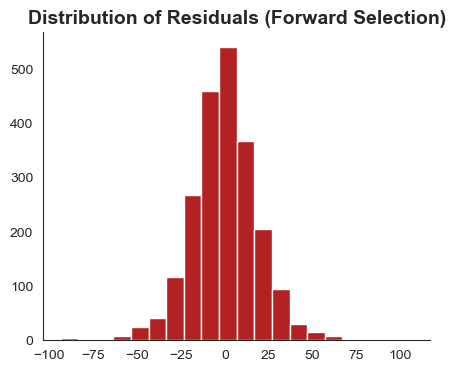

In [33]:
residuals_forsel = FOR_SEL_model.resid

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals_forsel, bins = 20, color = "firebrick")
    
plt.title(label = "Distribution of Residuals (Forward Selection)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

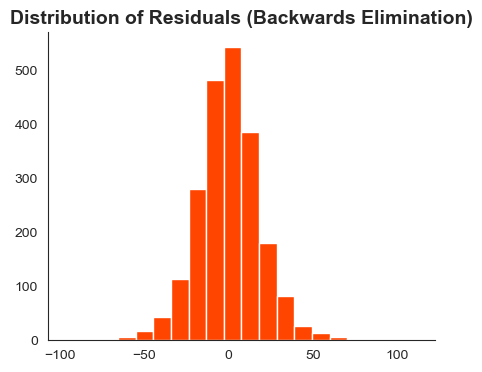

In [34]:
residuals_backel = BACK_EL_model.resid

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals_backel, bins = 20, color = "orangered")
    
plt.title(label = "Distribution of Residuals (Backwards Elimination)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

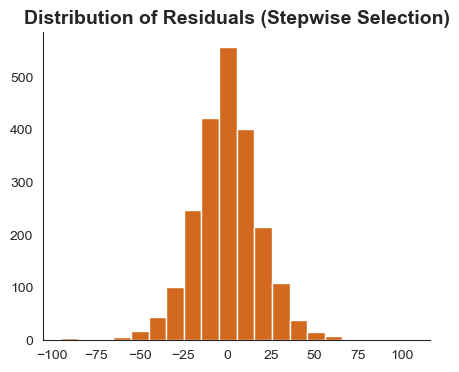

In [35]:
residuals_stepsel = STEP_SEL_model.resid

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals_stepsel, bins = 20, color = "chocolate")
    
plt.title(label = "Distribution of Residuals (Stepwise Selection)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

The performance of these models remains consistent across all methods. In the stepwise selection model, the residuals appear to be more evenly distributed. However, for the other models, a larger proportion of predictions are closer to the actual value of y, resulting in a higher frequency of residuals being zero.

__Difference in predictor selection__

In [36]:
len(X_train_for.columns)

15

In [37]:
len(X_train_back.columns)

18

In [38]:
len(X_train_step.columns)

13

Furthermore, it's worth noting that the various selection methods result in the selection of different predictors.

__Saving the Results__

In [39]:
Linear_Regression_Models_Part2_Results.to_csv(r'Linear_Regression_Models_Part2_Results.csv', index=True, 
                                              index_label= 'Metrics')